# Training in mini-batches

## Why minibatch vs batch gradient descent?

Sometimes we have so much data that it will not fit on our GPU, which typically has around 12G of RAM.  For big problems, we need to break it up into batches.
 
Also, and possibly a more important goal, is to get better generalization; i.e., smaller validation loss. We want batch size to be as large as possible for efficiency on GPUs, but as small as possible to get the stochastic bouncing around down into lower minima.

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)

In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

In [3]:
d = load_diabetes()
len(d.data)

442

In [4]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [5]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [6]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [7]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 1173.47 validation MSE 3217.85


In [8]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Minibatch stochastic gradient descent (SGD)

In [9]:
def sgdtrain(model, X_train, X_test, y_train, y_test,
             learning_rate = .5, nepochs=2000, weight_decay=0, batch_size=32,
             trace=True):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = []
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            loss = 0
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            loss = torch.mean((y_pred - batch_y)**2)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()
        
        epoch_training_loss /= nbatches # average batch loss

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((epoch_training_loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {epoch_training_loss:12.3f}   test loss {loss_test:12.3f}")

    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    28953.280   test loss    22313.480
Epoch   10 MSE train loss     2497.848   test loss     3698.753
Epoch   20 MSE train loss     2070.746   test loss     3653.657
Epoch   30 MSE train loss     2168.326   test loss     3986.203
Epoch   40 MSE train loss     2310.239   test loss     4180.412
Epoch   50 MSE train loss     1552.980   test loss     3924.475
Epoch   60 MSE train loss     2612.845   test loss     3629.099
Epoch   70 MSE train loss     1744.356   test loss     4364.985
Epoch   80 MSE train loss     1599.460   test loss     3922.154
Epoch   90 MSE train loss     1770.545   test loss     4491.231
Epoch  100 MSE train loss     1956.445   test loss     4579.105
BEST MSE test loss 3460.430
MSE test loss 3460.430


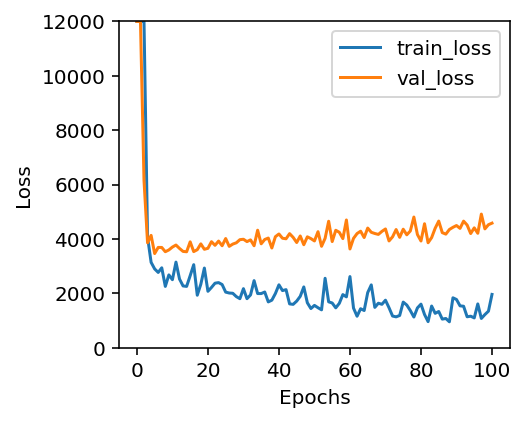

In [16]:
ncols = X.shape[1]
n_neurons = 1000
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.BatchNorm1d(n_neurons),
    nn.Linear(n_neurons, 1)
)

history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                               learning_rate=.01, nepochs=100, batch_size=32)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))

Epoch    0 MSE train loss     6216.710   test loss     4643.111
Epoch   10 MSE train loss     3352.294   test loss     4167.205
Epoch   20 MSE train loss     2853.388   test loss     3602.769
Epoch   30 MSE train loss     2472.568   test loss     3618.931
Epoch   40 MSE train loss     2276.738   test loss     4531.579
Epoch   50 MSE train loss     2063.064   test loss     5153.692
Epoch   60 MSE train loss     2139.291   test loss     4625.632
Epoch   70 MSE train loss     2009.666   test loss     5360.181
Epoch   80 MSE train loss     1896.653   test loss     5229.639
Epoch   90 MSE train loss     1942.172   test loss     4963.056
Epoch  100 MSE train loss     1767.830   test loss     5238.248
BEST MSE test loss 3132.790
Epoch    0 MSE train loss    14736.096   test loss     6728.824
Epoch   10 MSE train loss     2727.246   test loss     3285.019
Epoch   20 MSE train loss     2616.630   test loss     3819.731
Epoch   30 MSE train loss     2375.890   test loss     4179.650
Epoch   40 M

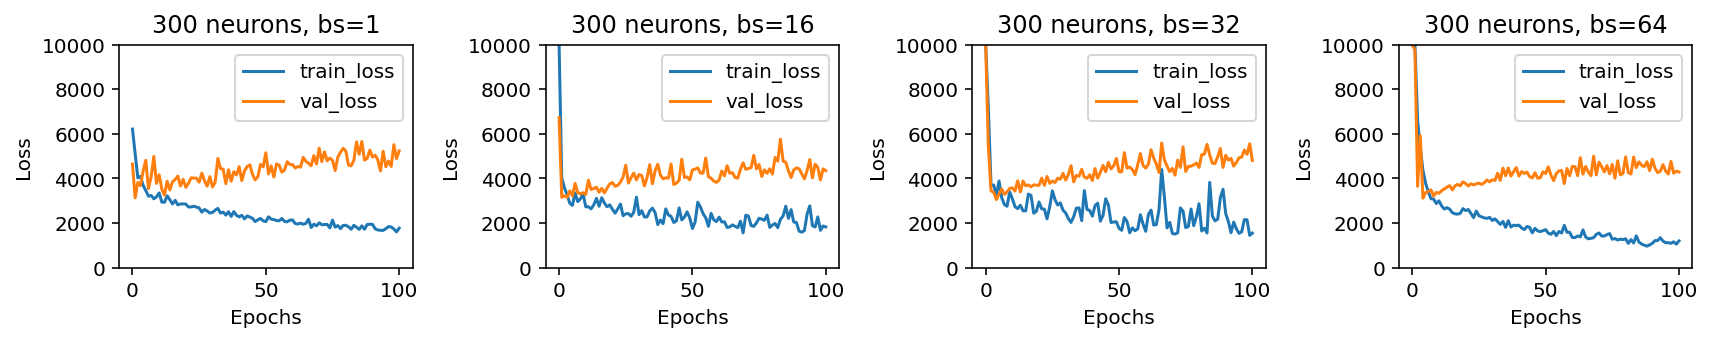

In [22]:
fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

n_neurons = 300
for bs,ax in zip([1,16,32,64],axes):
    if bs>1:
        model = nn.Sequential(
            nn.Linear(ncols, n_neurons),
            nn.ReLU(),
            nn.BatchNorm1d(n_neurons),
            nn.Linear(n_neurons, 1)
        )
    else:
        model = nn.Sequential(
            nn.Linear(ncols, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 1)
        )
    history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                                   learning_rate=.05, nepochs=100, batch_size=bs,
                                   trace=True)
    ax.set_title(f"{n_neurons} neurons, bs={bs}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()